## Time Series Analysis Methods

In this chapter we want to introduce somehands-on time series analysis methods.

In [1]:
%load_ext lab_black

### The Keeling Curve


For the purpose of demonstration we download a data set of carbon dioxide (CO<sub>2</sub>) measurements taken at the [Mauna Loa Observatory](https://en.wikipedia.org/wiki/Mauna_Loa_Observatory) in Hawaii, the so called [Keeling Curve](https://en.wikipedia.org/wiki/Keeling_Curve). 

 
CO2 PPM - Trends in Atmospheric Carbon Dioxide. Data are sourced from the US Government's Earth System Research Laboratory, Global Monitoring Division.
Mauna Loa series (which has the longest continuous series since 1958)

The data is downloaded from: https://datahub.io/core/co2-ppm#data
and provided by: Trends in Atmospheric Carbon Dioxide, Mauna Loa, Hawaii. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

In [2]:
# First, let's import all the needed libraries.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

In [3]:
# Read the data set:
df = pd.read_csv("data/co2-mm-mlo.csv", sep=",")

In [4]:
df.columns

Index(['Date', 'Decimal Date', 'Average', 'Interpolated', 'Trend',
       'Number of Days'],
      dtype='object')

In [5]:
##look at the date format:
df["Date"]

0      1958-03-01
1      1958-04-01
2      1958-05-01
3      1958-06-01
4      1958-07-01
          ...    
722    2018-05-01
723    2018-06-01
724    2018-07-01
725    2018-08-01
726    2018-09-01
Name: Date, Length: 727, dtype: object

In [6]:
# convert date object to datetime
df["Date"] = pd.to_datetime(df["Date"])

# set the 'Datum' columns as index:
df = df.set_index("Date")

In [7]:
df

,Decimal Date,Average,Interpolated,Trend,Number of Days
Date,,,,,
1958-03-01,1958.208,315.71,315.71,314.62,-1
1958-04-01,1958.292,317.45,317.45,315.29,-1
1958-05-01,1958.375,317.50,317.50,314.71,-1
1958-06-01,1958.458,-99.99,317.10,314.85,-1
1958-07-01,1958.542,315.86,315.86,314.98,-1
...,...,...,...,...,...
2018-05-01,2018.375,411.24,411.24,407.91,24
2018-06-01,2018.458,410.79,410.79,408.49,29
2018-07-01,2018.542,408.71,408.71,408.32,27


<Axes: xlabel='Date'>

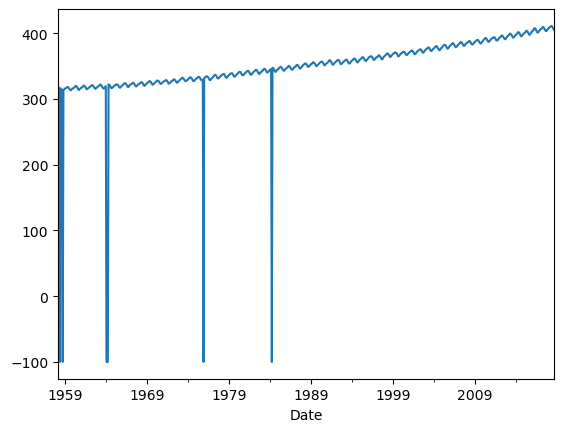

In [8]:
df["Average"].plot()

The average column contains the monthly mean CO2 mole fraction determined from daily averages. The mole fraction of CO2, expressed as parts per million (ppm) is the number of molecules of CO2 in every one million molecules of dried air (water vapor removed). Missing months are denoted by −99.99. 

To get an impression of the curve let us drop the mising month.

In [9]:
df = df[df.Average != -99.99]

In [10]:
df

,Decimal Date,Average,Interpolated,Trend,Number of Days
Date,,,,,
1958-03-01,1958.208,315.71,315.71,314.62,-1
1958-04-01,1958.292,317.45,317.45,315.29,-1
1958-05-01,1958.375,317.50,317.50,314.71,-1
1958-07-01,1958.542,315.86,315.86,314.98,-1
1958-08-01,1958.625,314.93,314.93,315.94,-1
...,...,...,...,...,...
2018-05-01,2018.375,411.24,411.24,407.91,24
2018-06-01,2018.458,410.79,410.79,408.49,29
2018-07-01,2018.542,408.71,408.71,408.32,27


<Axes: xlabel='Date'>

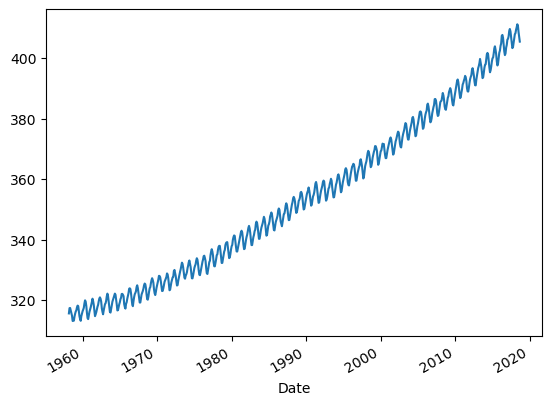

In [11]:
df["Average"].plot()

This characteristic graph showing the rising the CO2 concentration over time is often referred to as [Keeling Curve](https://en.wikipedia.org/wiki/Keeling_Curve). Each year when the terrestrial vegetation of the Northern Hemisphere expands with the seasons, it removes CO2 from the atmosphere in its productive growing phase, while it returns CO2 to the air when it dies and decomposes. This phenomenon creates a seasonal oscillation in the atmosphere’s CO2 concentration.



### Seasonal decompositon

Time series data can exhibit a huge variety of temporal patterns. In many cases it is useful to categorize these patterns, and further,  split them up into distinct components. In general many time series can be decomposed into three parts:

* __Trend__: A trend exists when there is a long-term increase or decrease in the data. 
* __Seasonal pattern__:  A seasonal pattern exists when a series is influenced by seasonal factors. Seasonality is always of a fixed and known period.  
* __Residual__:  The remainder, after accounting for the trend and seasonality; also known as [noise](https://en.wikipedia.org/wiki/White_noise).

We can principally model such a time series in two ways: as an **additive model** and as a **multiplicative model**.


The additive model can be written as

$$y_t = T_t + S_t + E_t\text{,}$$

and the multiplicative model can be written as 

$$y_t = T_t \times S_t \times E_t\text{,}$$

where $y_t$ is the data at period $t$, $T_t$ is the trend-cycle component, $S_t$ is the seasonal component and $E_t$ is the remainder component at period $t$.


>The **additive model** is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not change with a trend of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a **multiplicative mode** is more appropriate.








#### STL decomposition

STL is an acronym for “Seasonal and Trend decomposition using Loess”, while loess (locally weighted regression and scatterplot smoothing) is a method for estimating nonlinear relationships.

In [12]:
register_matplotlib_converters()
sns.set_style("darkgrid")

In [13]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [14]:
# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(
    df["Average"], model="add", extrapolate_trend="freq", period=1
)

> **Why do we get an error message here possibly?**
> 
> Because we have missing data! Therefore, we first have to tackle this problem! 

<Axes: xlabel='Date'>

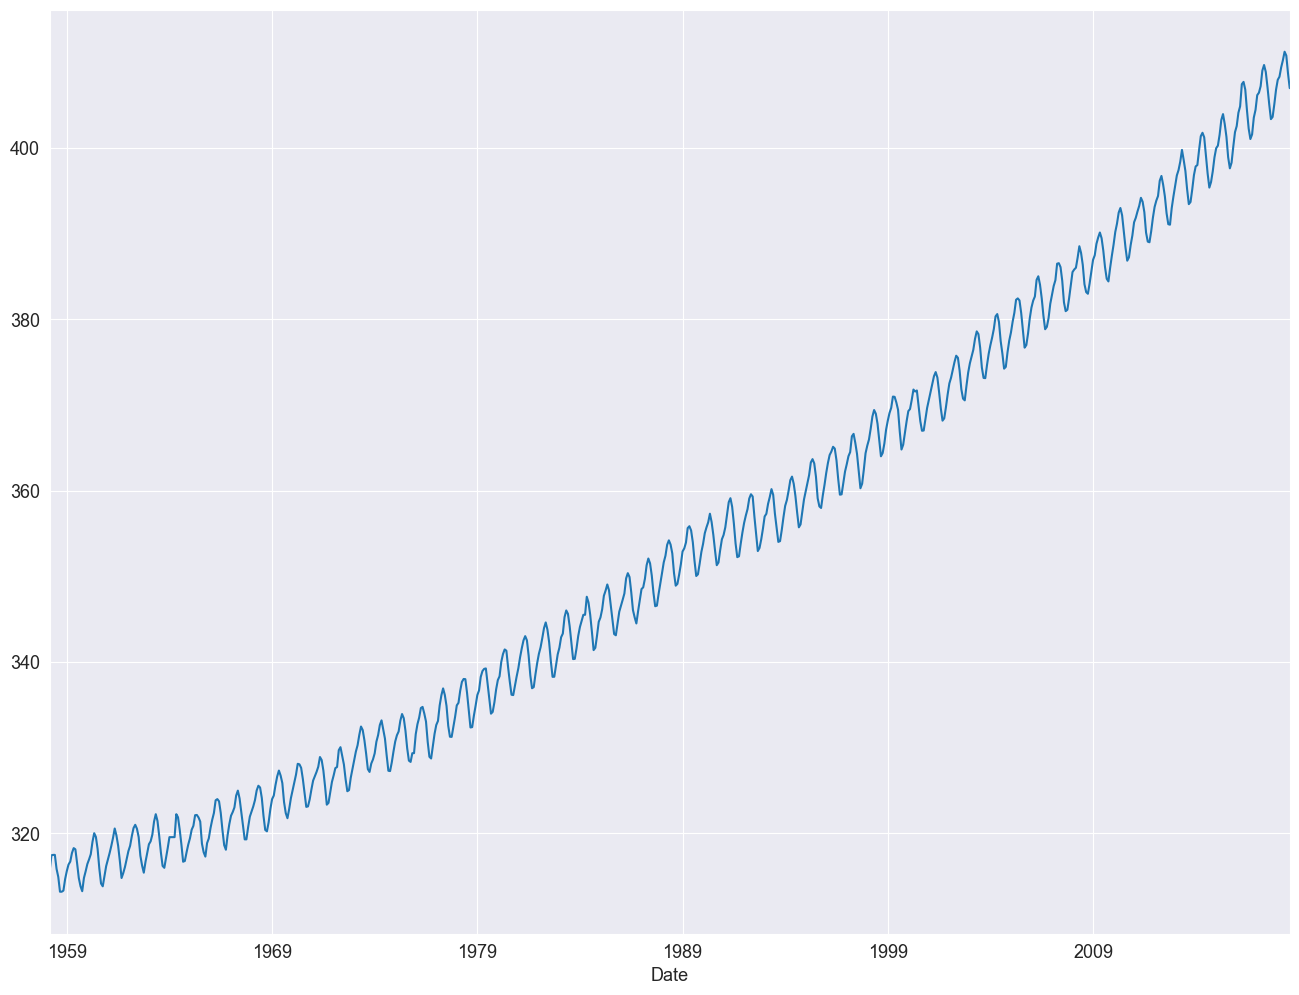

In [15]:
df = df.asfreq("ME", method="ffill")
df["Average"].plot()

In [16]:
df

,Decimal Date,Average,Interpolated,Trend,Number of Days
Date,,,,,
1958-03-31,1958.208,315.71,315.71,314.62,-1
1958-04-30,1958.292,317.45,317.45,315.29,-1
1958-05-31,1958.375,317.50,317.50,314.71,-1
1958-06-30,1958.375,317.50,317.50,314.71,-1
1958-07-31,1958.542,315.86,315.86,314.98,-1
...,...,...,...,...,...
2018-04-30,2018.292,410.24,410.24,407.45,21
2018-05-31,2018.375,411.24,411.24,407.91,24
2018-06-30,2018.458,410.79,410.79,408.49,29


#### Additive Decomposition

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Decomposition
result = seasonal_decompose(df["Average"], model="additive", extrapolate_trend="freq")

In [18]:
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

Date
1958-03-31    315.181196
1958-04-30    315.230983
1958-05-31    315.280771
1958-06-30    315.330558
1958-07-31    315.380345
                 ...    
2018-04-30    408.006437
2018-05-31    408.163232
2018-06-30    408.320027
2018-07-31    408.476822
2018-08-31    408.633616
Freq: ME, Name: trend, Length: 726, dtype: float64
Date
1958-03-31    1.423431
1958-04-30    2.530454
1958-05-31    3.020961
1958-06-30    2.322923
1958-07-31    0.695820
                ...   
2018-04-30    2.530454
2018-05-31    3.020961
2018-06-30    2.322923
2018-07-31    0.695820
2018-08-31   -1.447539
Freq: ME, Name: seasonal, Length: 726, dtype: float64
Date
1958-03-31   -0.894627
1958-04-30   -0.311437
1958-05-31   -0.801732
1958-06-30   -0.153481
1958-07-31   -0.216166
                ...   
2018-04-30   -0.296891
2018-05-31    0.055807
2018-06-30    0.147051
2018-07-31   -0.462642
2018-08-31   -0.196077
Freq: ME, Name: resid, Length: 726, dtype: float64
Date
1958-03-31    315.71
1958-04-30    317.45
1

These four time series can be plotted directly from the result object by calling the plot() function. For example:


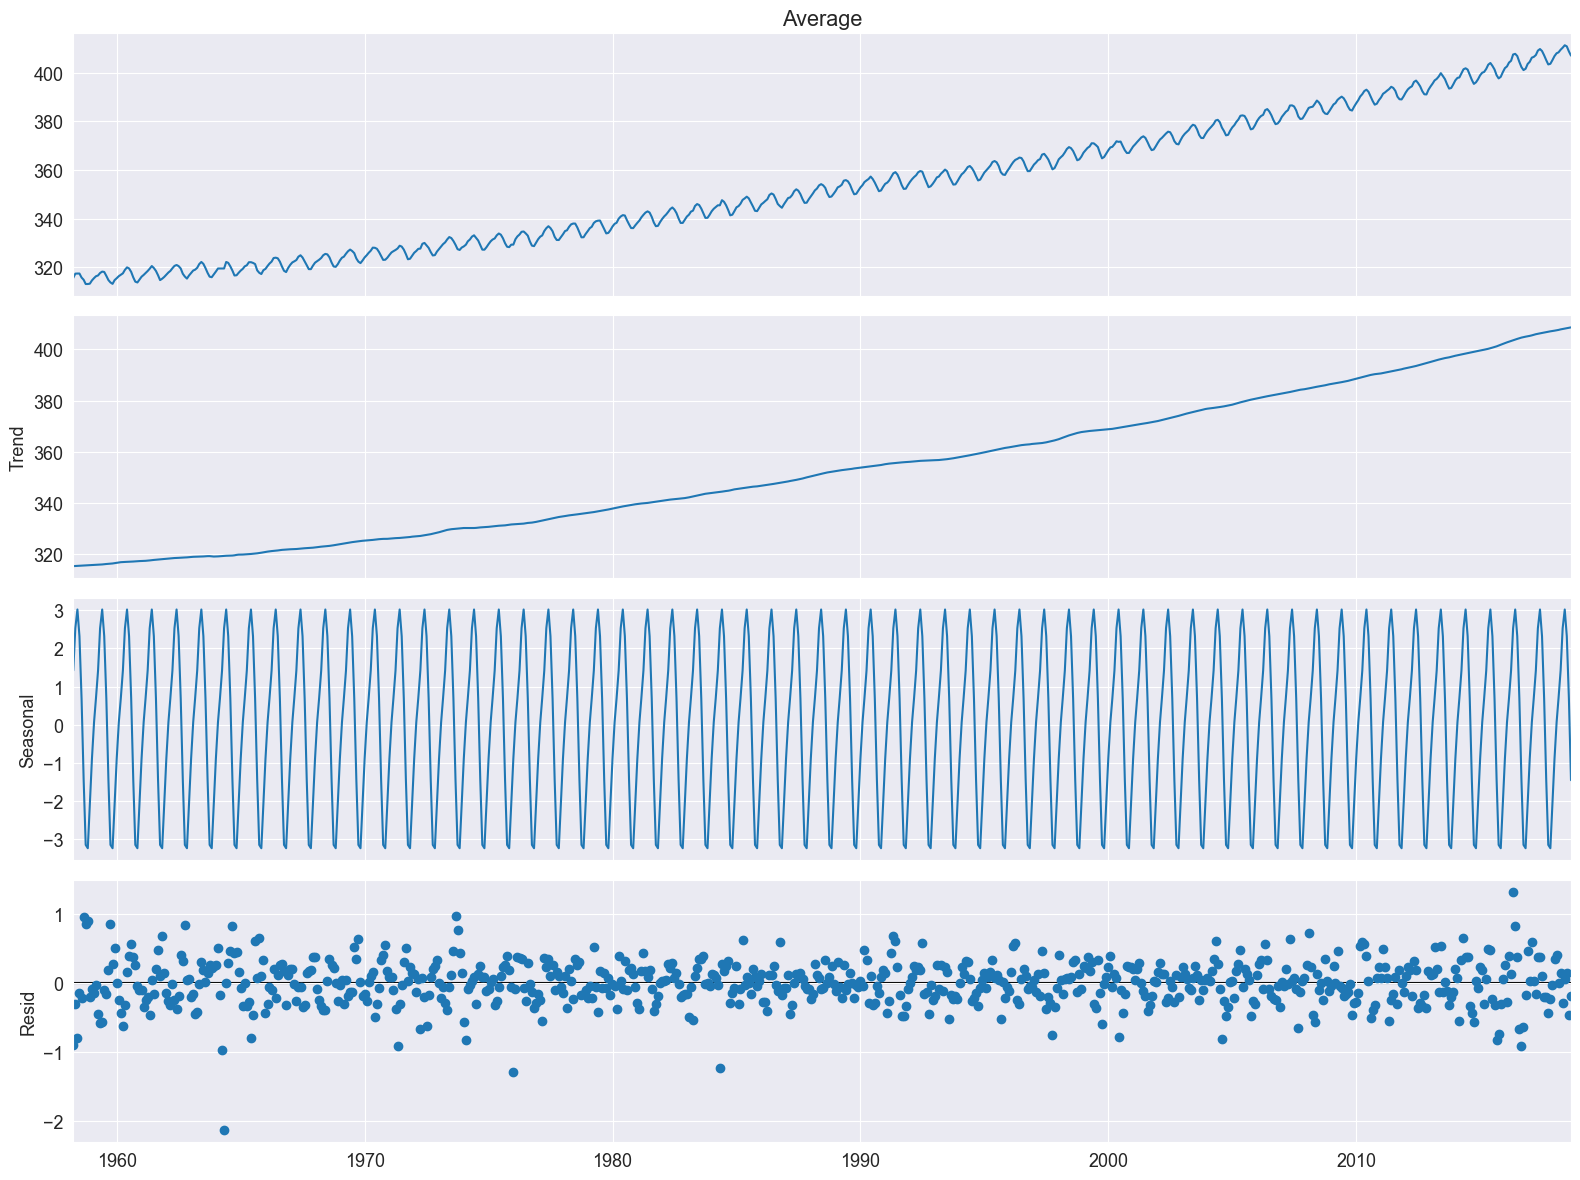

In [19]:
from matplotlib import pyplot

result.plot()
pyplot.show()

The plot shows four panels. In the uppermost we see the raw data, the Keeling curve. In the subsequent plot we see the trend component, the seasonal component and the remainder. We realize a very strong linear trend in the data set. Let us redo the analysis, however this time we focus on the 21st century.

In [20]:
df_2000to2020 = df["2000-01-01":"2020-01-01"]

In [21]:
df_2000to2020

,Decimal Date,Average,Interpolated,Trend,Number of Days
Date,,,,,
2000-01-31,2000.042,369.29,369.29,369.08,26
2000-02-29,2000.125,369.54,369.54,368.83,19
2000-03-31,2000.208,370.60,370.60,369.09,30
2000-04-30,2000.292,371.81,371.81,369.28,27
2000-05-31,2000.375,371.58,371.58,368.71,28
...,...,...,...,...,...
2018-04-30,2018.292,410.24,410.24,407.45,21
2018-05-31,2018.375,411.24,411.24,407.91,24
2018-06-30,2018.458,410.79,410.79,408.49,29


<Axes: xlabel='Date'>

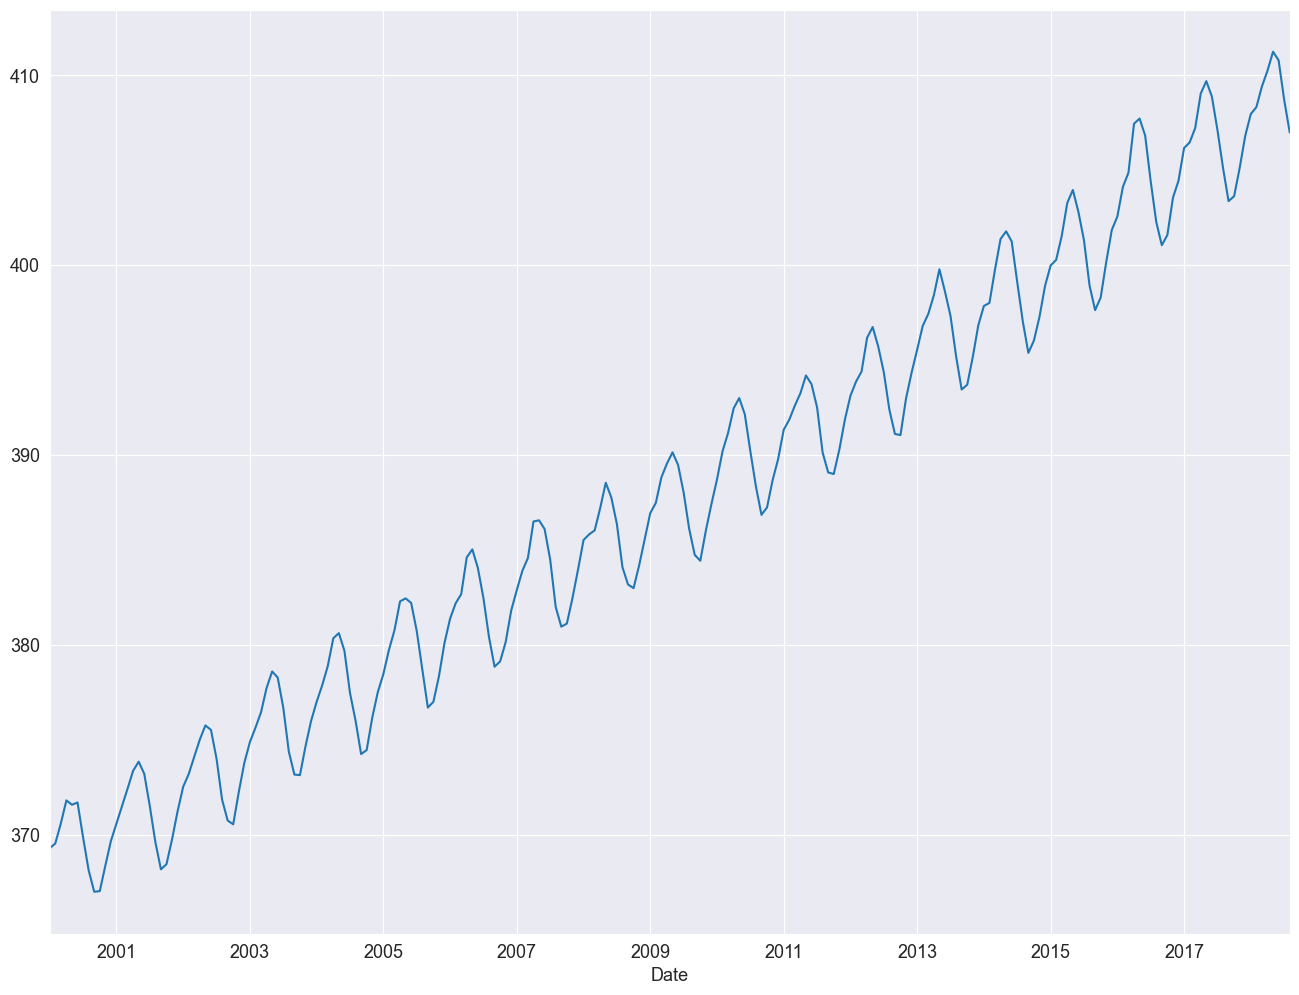

In [22]:
df_2000to2020["Average"].plot()

In [23]:
# Time Series Decomposition
result_add = seasonal_decompose(
    df_2000to2020["Average"], model="additive", extrapolate_trend="freq"
)

In [24]:
print(result_add.trend)
print(result_add.seasonal)
print(result_add.resid)
print(result_add.observed)

Date
2000-01-31    368.826526
2000-02-29    368.961396
2000-03-31    369.096267
2000-04-30    369.231137
2000-05-31    369.366007
                 ...    
2018-04-30    408.006437
2018-05-31    408.163232
2018-06-30    408.320027
2018-07-31    408.476822
2018-08-31    408.633616
Freq: ME, Name: trend, Length: 224, dtype: float64
Date
2000-01-31    0.257498
2000-02-29    0.821035
2000-03-31    1.535074
2000-04-30    2.747596
2000-05-31    3.155601
                ...   
2018-04-30    2.747596
2018-05-31    3.155601
2018-06-30    2.321368
2018-07-31    0.456473
2018-08-31   -1.771099
Freq: ME, Name: seasonal, Length: 224, dtype: float64
Date
2000-01-31    0.205976
2000-02-29   -0.242431
2000-03-31   -0.031341
2000-04-30   -0.168733
2000-05-31   -0.941608
                ...   
2018-04-30   -0.514033
2018-05-31   -0.078832
2018-06-30    0.148605
2018-07-31   -0.223295
2018-08-31    0.127483
Freq: ME, Name: resid, Length: 224, dtype: float64
Date
2000-01-31    369.29
2000-02-29    369.54
2

These four time series can be plotted directly from the result object by calling the plot() function. For example:
from matplotlib import pyplot

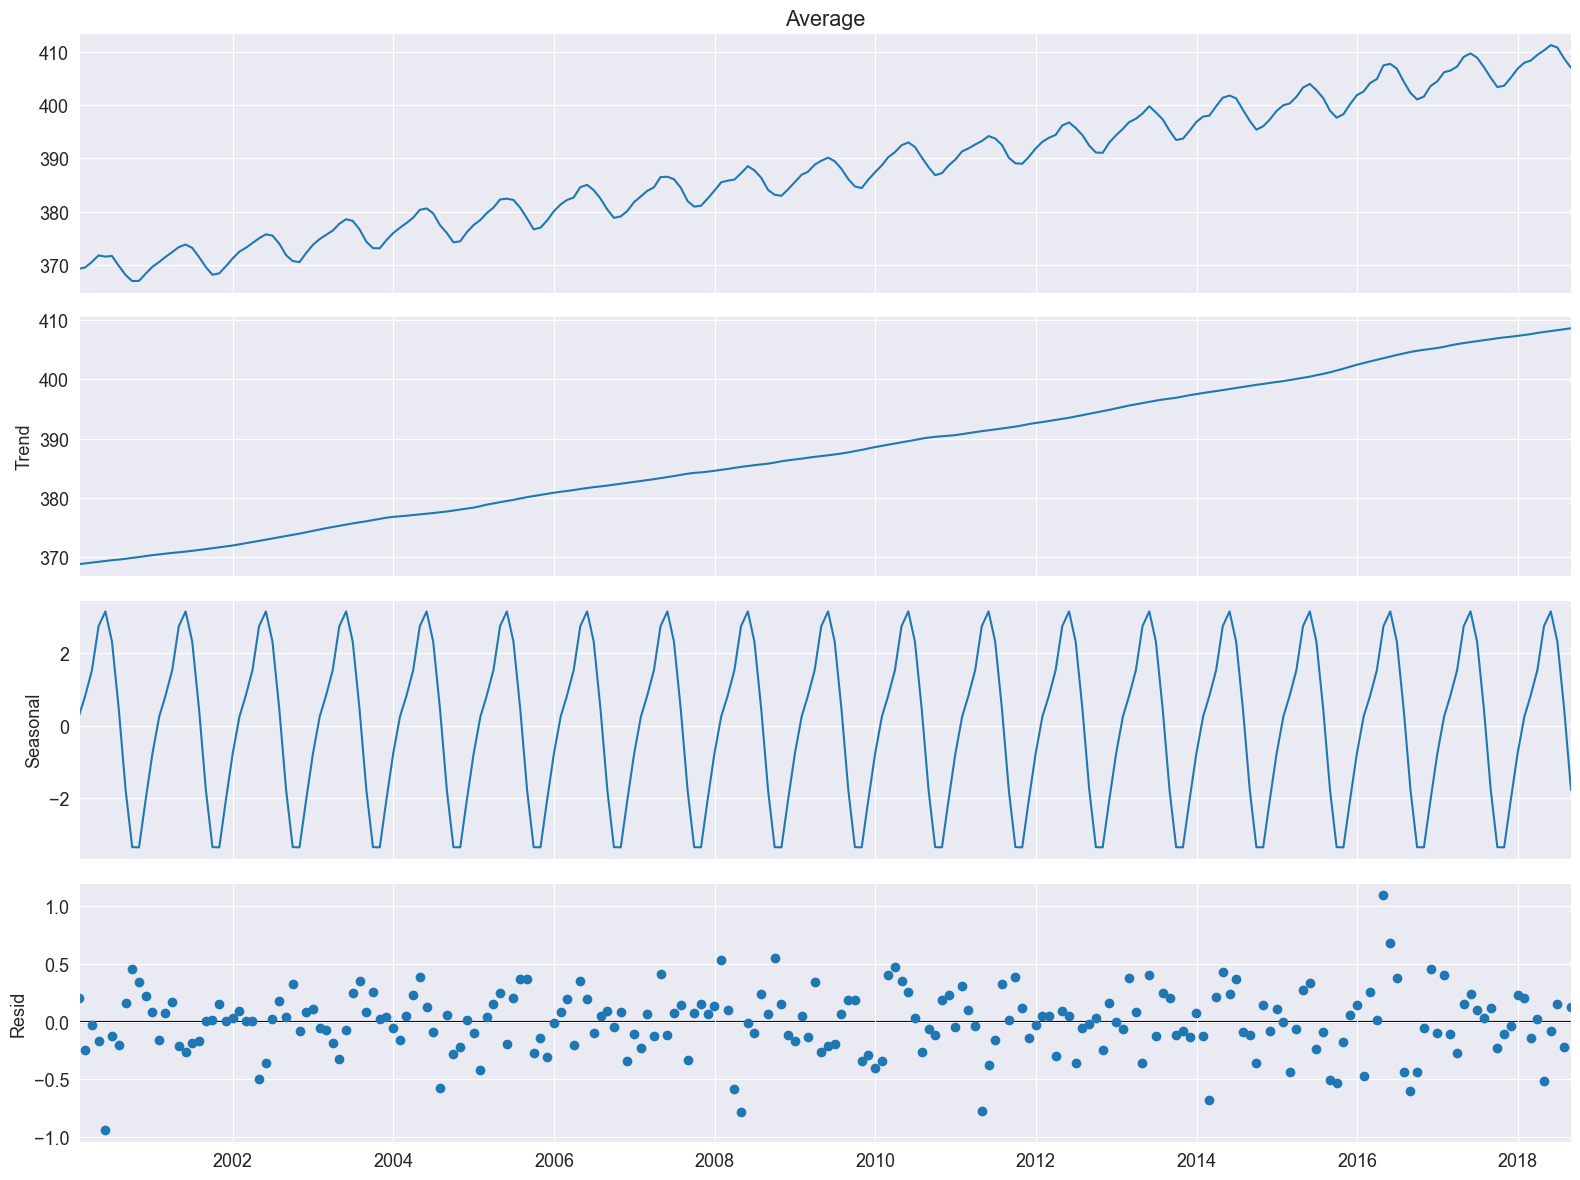

In [25]:
from matplotlib import pyplot

result_add.plot()
pyplot.show()

Nice, plot! The bars at its right side are of equal heights in user coordinates. This time it is much easier to spot the seasonal oscillation in the CO2 concentration. The remainder seems quite noisy and is devoid of a particular pattern. This indicates that the seasonal decomposition did a good job in extracting the trend and seasonal components.

#### Multiplicative Decomposition


In [26]:
# Time Series Decomposition
result = seasonal_decompose(
    df_2000to2020["Average"], model="multiplicative", extrapolate_trend="freq"
)

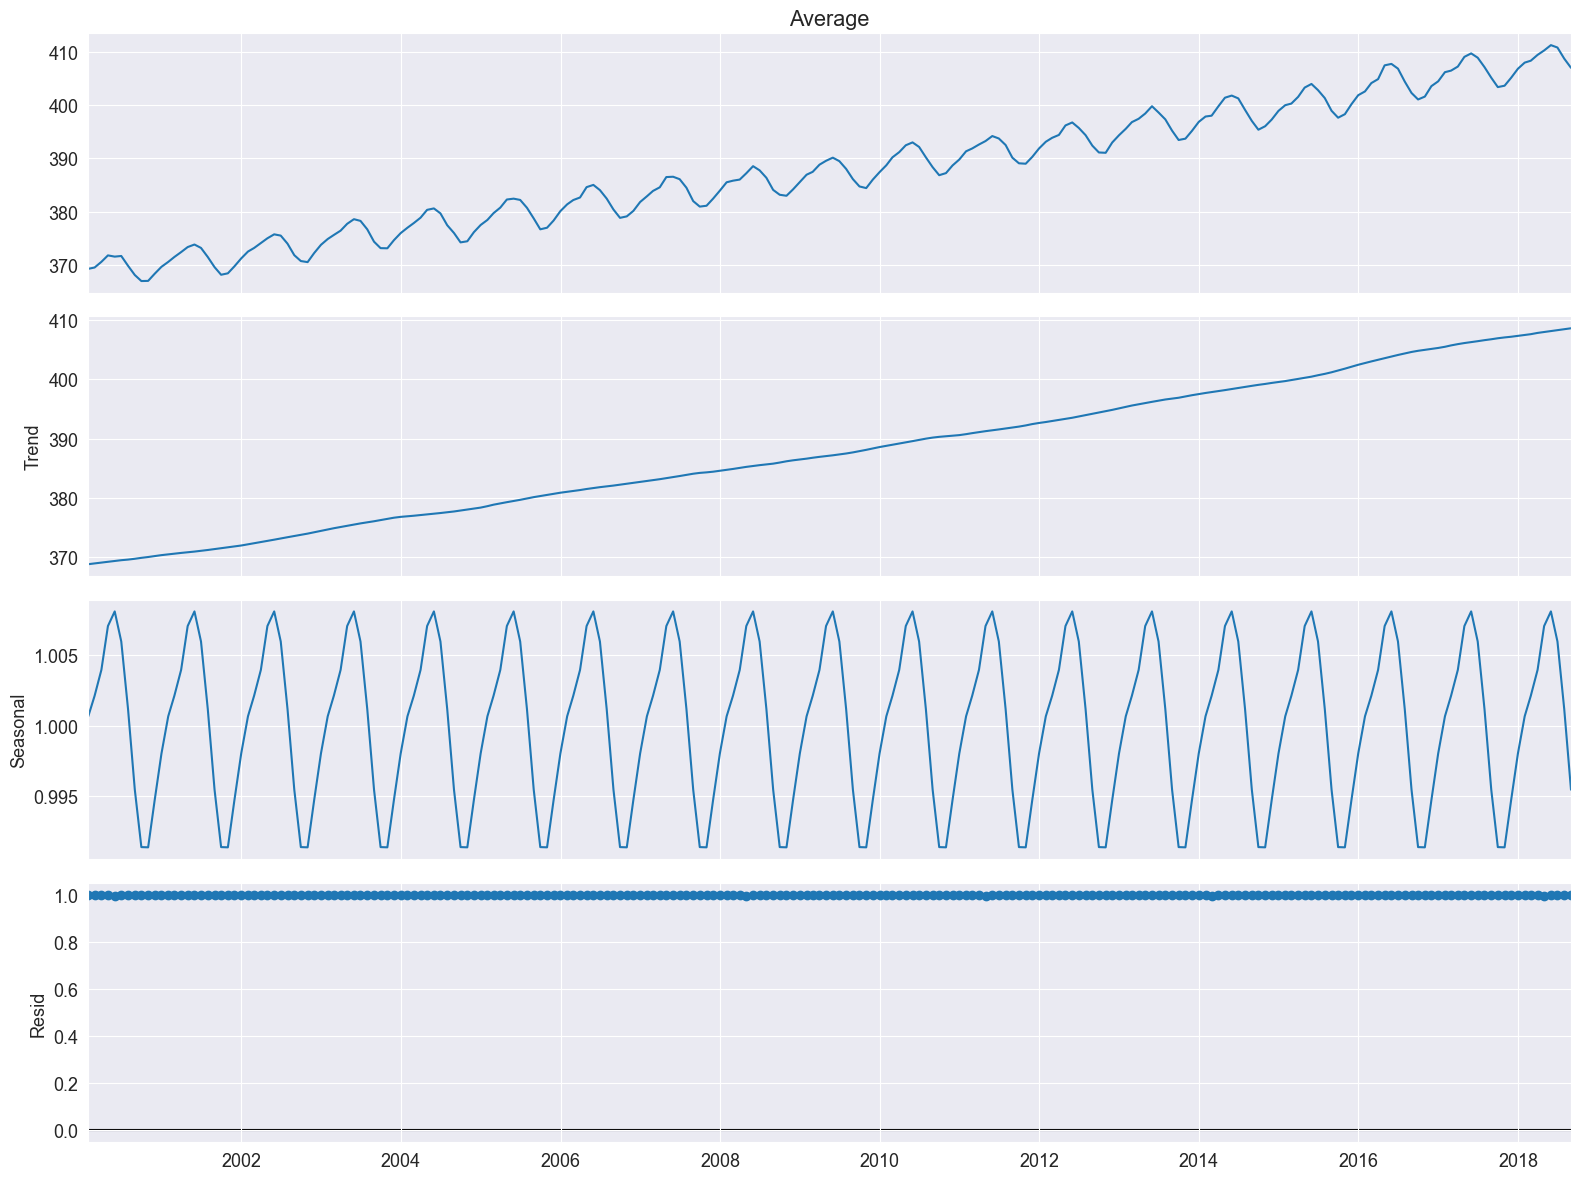

In [27]:
result.plot()
pyplot.show()

We see the residuals are all 1. This is a hint that we the multiplicative model is not appropriate. 



***

A very typical use case is to apply STL for detrending a time series. We detrend our data set by subtracting the trend from the original data.


$$y_t^* = y_t- T_t$$


In [28]:
detrended = df_2000to2020["Average"] - result_add.trend

Text(0, 0.5, 'CO2')

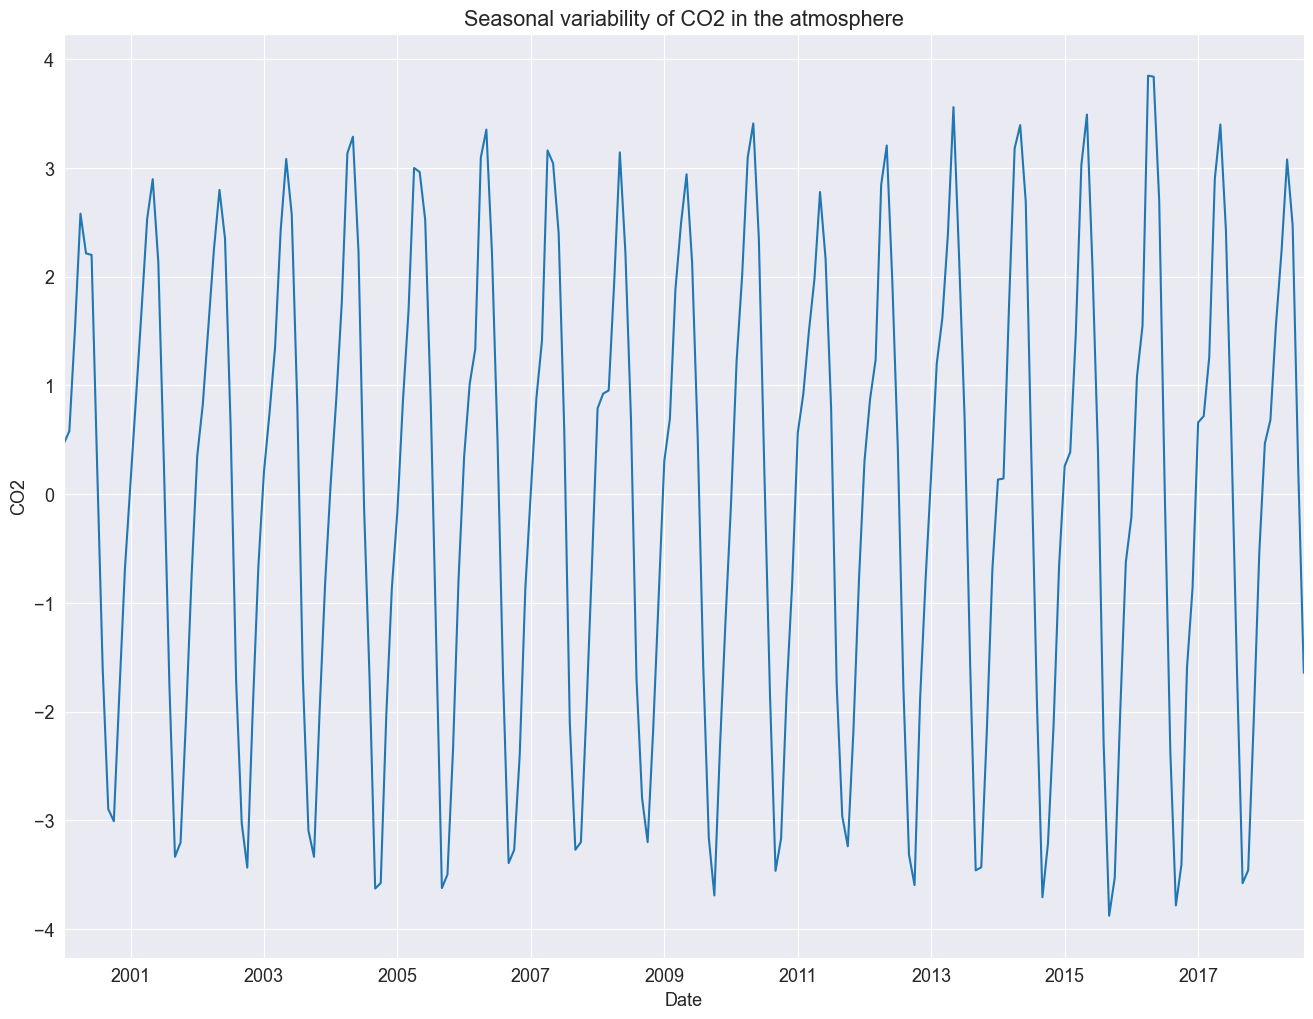

In [29]:
detrended.plot()
plt.title("Seasonal variability of CO2 in the atmosphere")
plt.ylabel("CO2")

***


Let us investigate the remainder and review if the residuals are normally distributed.  


Text(0, 0.5, 'CO2')

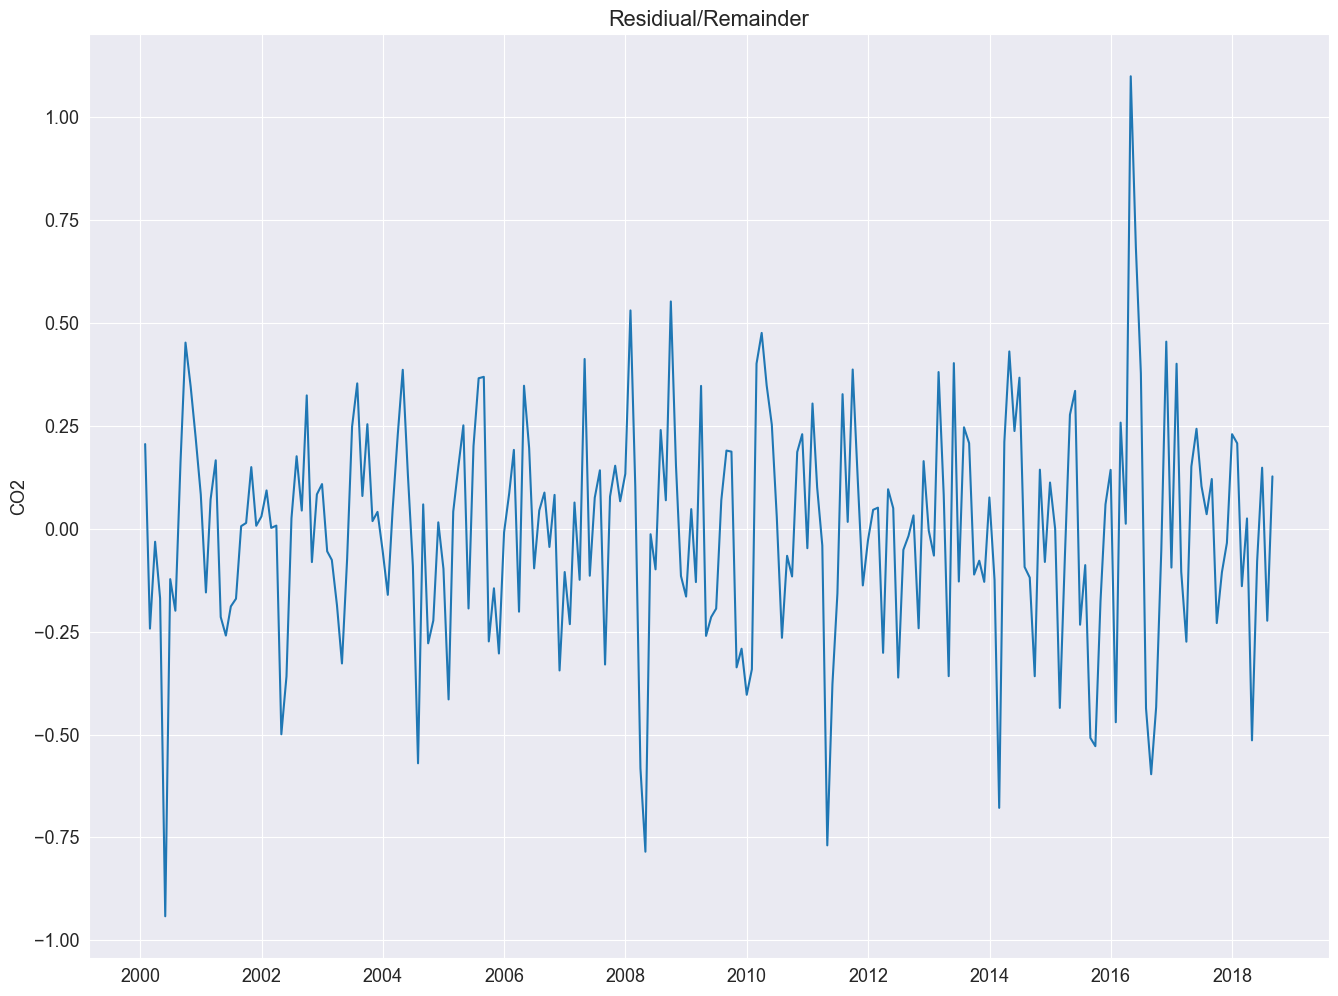

In [30]:
plt.plot(result_add.resid)
plt.title("Residiual/Remainder")
plt.ylabel("CO2")

Next, wec reate a QQ-plot using the qqnorm() and the qqline() function to check the distribution of the residuals.


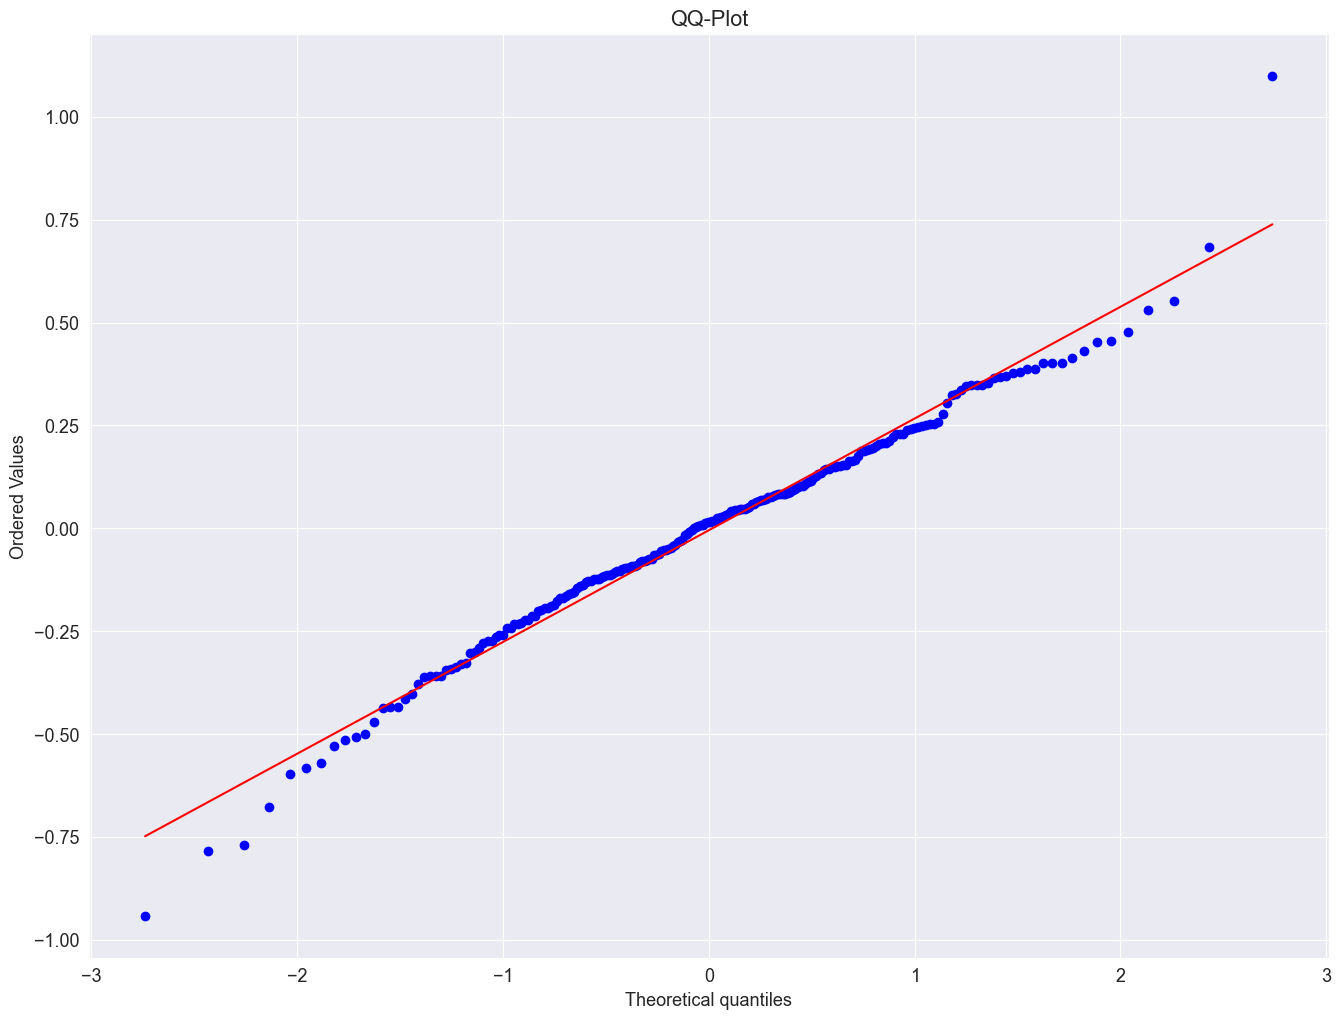

In [31]:
import scipy.stats as stats

plt.figure()
stats.probplot(result_add.resid, dist="norm", plot=plt)
plt.title("QQ-Plot")
plt.show()

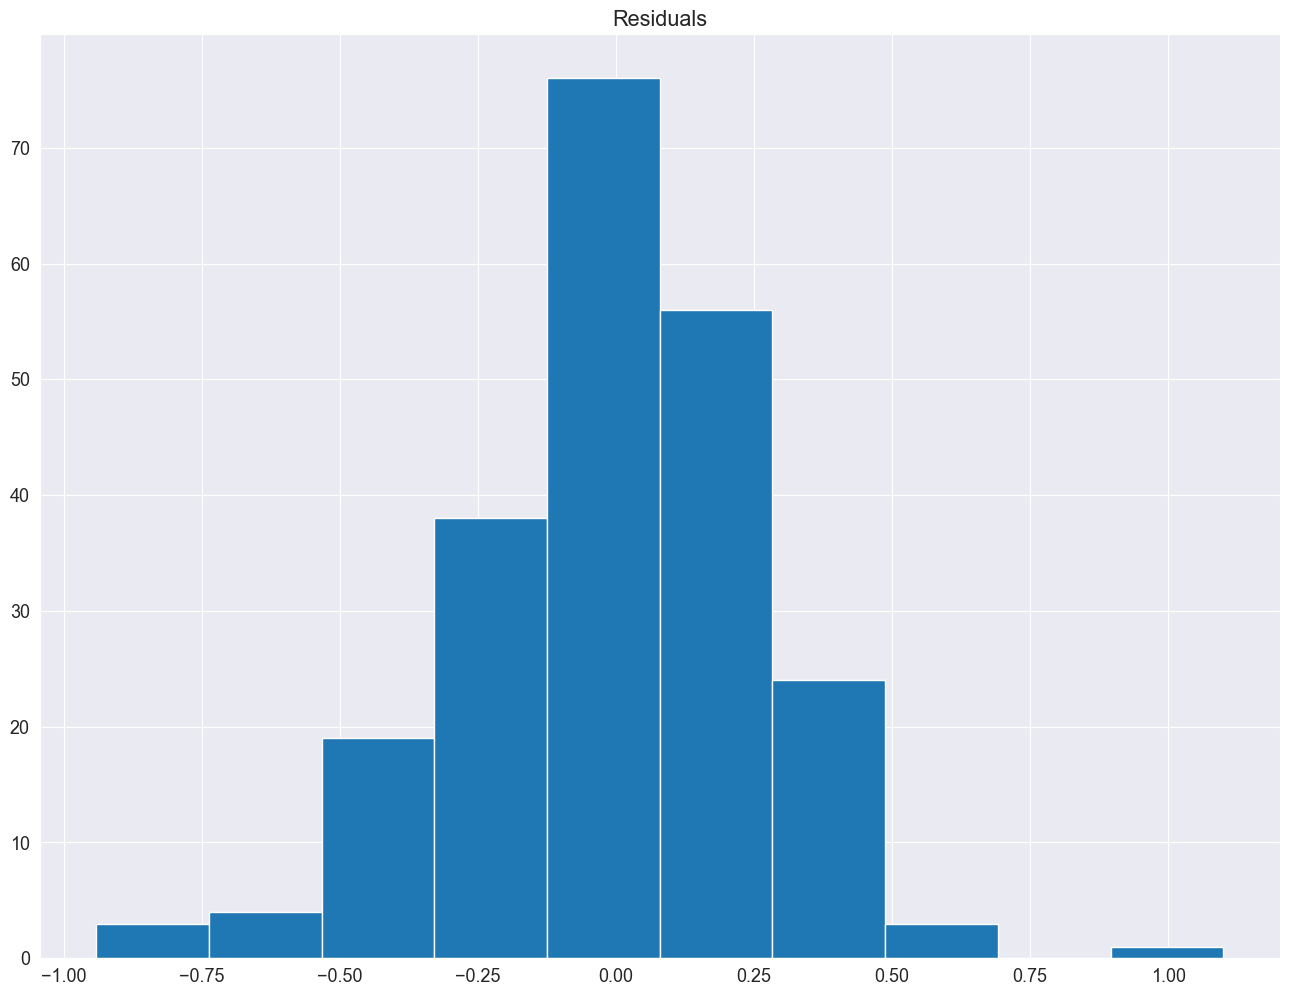

In [32]:
# histogram plot
pyplot.hist(result_add.resid)
pyplot.title("Residuals")
pyplot.show()

The residuals seem fairly well normally distributed. This means, that we considered an appropriate model. 

Additionally you can apply a [Shapiro–Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) and check for normality. 



In [33]:
from IPython.display import IFrame

IFrame(
    src="../citations/citation_Soga.html",
    width=900,
    height=200,
)